### Import neccesary libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default") 

### Define the split type and stock name


In [4]:
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [5]:
split = 0
stock = 1  # CMG

## 1.Data preprocessing


In [6]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


<Axes: >

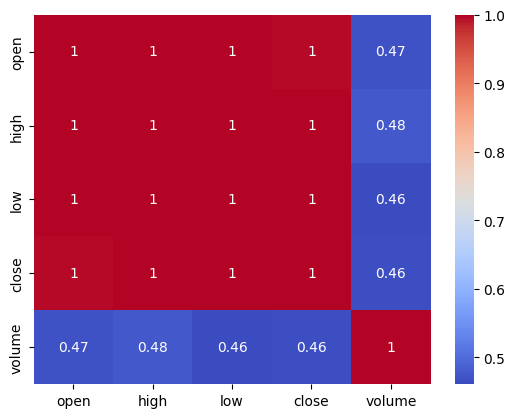

In [7]:
# Create a correlation matrix
df1 = df.drop(columns=["time", "ticker"], axis=1)
corr_matrix = df1.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Low price and close price are correlated => Good for forecast the "close price" in SARIMAX model

In [8]:
df = df[["low", "close"]] # Using low and close price to predict the next day close price, the low price is the exogenous variable

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


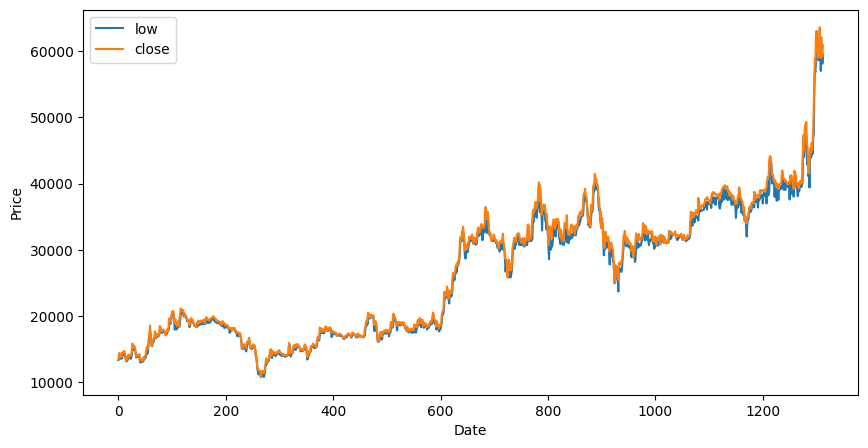

In [9]:
df.plot(figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [10]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [11]:
# Shape of the dataframe
df.shape

(1313, 2)

In [12]:
df.dtypes

low      int64
close    int64
dtype: object

In [13]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [14]:
# Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [15]:
# splitting data into train, test set
train_data = df[:train_size]
test_data = df[train_size:]

In [16]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

In [17]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963444,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [18]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [19]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.429
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.483
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


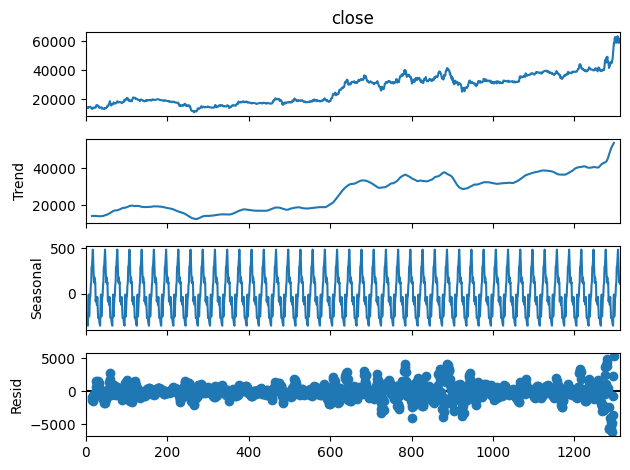

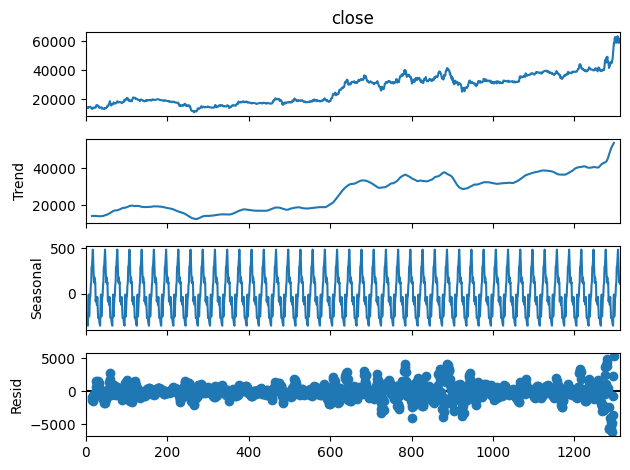

In [20]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [21]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [22]:
# Check again
adfuller(df_diff)

(-24.869647352545115,
 0.0,
 1,
 1047,
 {'1%': -3.4366111317433443,
  '5%': -2.864304451252086,
  '10%': -2.5682419034417707},
 16133.139050489852)

The p-value is less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

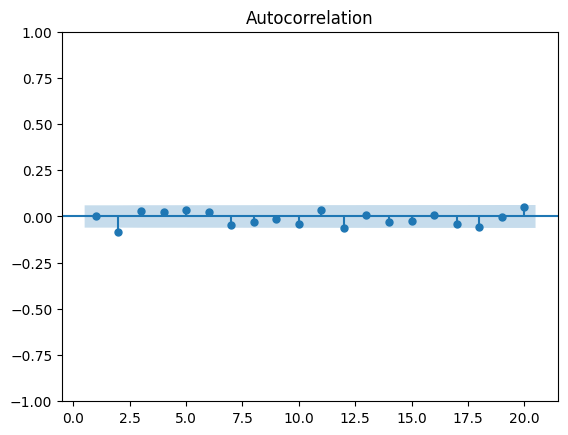

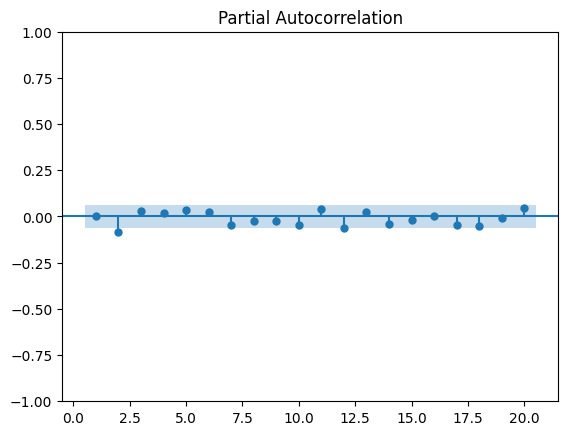

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [24]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [25]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16483.650, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=16486.468, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=16486.376, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16482.487, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=16484.497, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=16484.403, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=16485.947, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=16485.604, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=16485.598, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=16481.867, Time=0.21 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=16483.779, Time=0.23 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=16483.769, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=16485.701, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[5] i

In [26]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1050
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -8237.077
Date:                Thu, 20 Jun 2024   AIC                          16480.153
Time:                        06:56:53   BIC                          16495.020
Sample:                             0   HQIC                         16485.791
                               - 1050                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0123      0.021      0.597      0.551      -0.028       0.053
ma.L2         -0.0743      0.021     -3.472      0.001      -0.116      -0.032
sigma2      3.887e+05   1.07e+04     36.275      0.0

#### Use SARIMAX to train model


In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 2),
    seasonal_order=(0, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [28]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([32062.61804676, 31751.8569731 , 32150.22108331, 32039.04970372,
       31927.87832412, 31825.97122616, 31825.97122616, 31566.57134044,
       31714.79984657, 31714.79984657, 31751.8569731 , 31964.93545066,
       32150.22108331, 31927.87832412, 32150.22108331, 32437.41381393,
       34429.234365  , 34179.09876092, 34179.09876092, 33743.67752417,
       34651.57712419, 34762.74850379, 34466.29149153, 34179.09876092,
       34762.74850379, 35198.16974053, 34901.71272828, 34827.59847522,
       34827.59847522, 34901.71272828, 34466.29149153, 35633.59097728,
       35633.59097728, 35920.7837079 , 35920.7837079 , 35772.55520177,
       35920.7837079 , 35920.7837079 , 35920.7837079 , 35920.7837079 ,
       35920.7837079 , 36356.20494464, 36282.09069158, 36393.26207117,
       37004.70465894, 37004.70465894, 35994.89796096, 36865.74043445,
       37078.81891201, 36791.62618139, 36893.53327935, 36930.59040588,
       36643.39767526, 36791.62618139, 36207.97643852, 37366.01164263,
      

### Forecast the next 30/60/90 days


In [29]:
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [30]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [31]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Forecast closing prices for the next 30 days:")
print(y_30_days_pred)

Forecast closing prices for the next 30 days:
[39374.00360024 39407.18902296 39426.88566219 39446.58230142
 39466.27894066 39485.97557989 39505.67221912 39525.36885836
 39545.06549759 39564.76213682 39584.45877605 39604.15541529
 39623.85205452 39643.54869375 39663.24533299 39682.94197222
 39702.63861145 39722.33525068 39742.03188992 39761.72852915
 39781.42516838 39801.12180762 39820.81844685 39840.51508608
 39860.21172531 39879.90836455 39899.60500378 39919.30164301
 39938.99828225 39958.69492148]


### Plotting the data


In [32]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"Forecast {stock_name[stock]} Stock Price Using SARIMAX")
    plt.legend()
    plt.show()

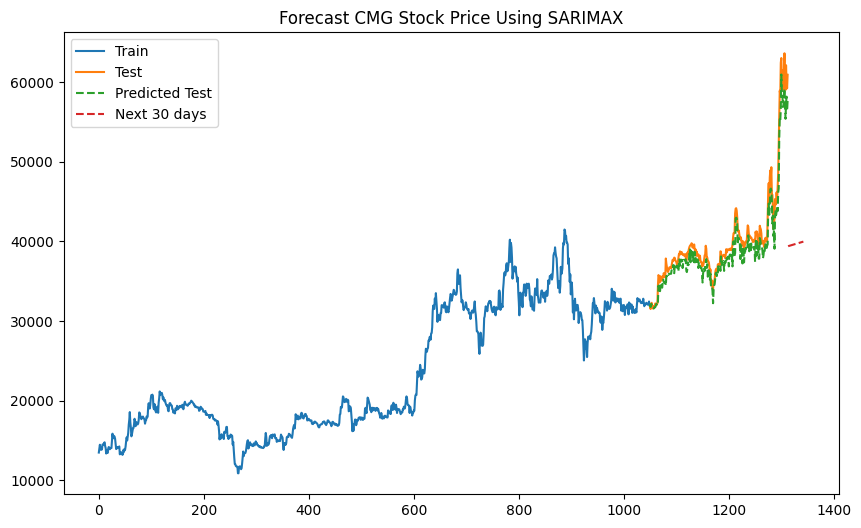

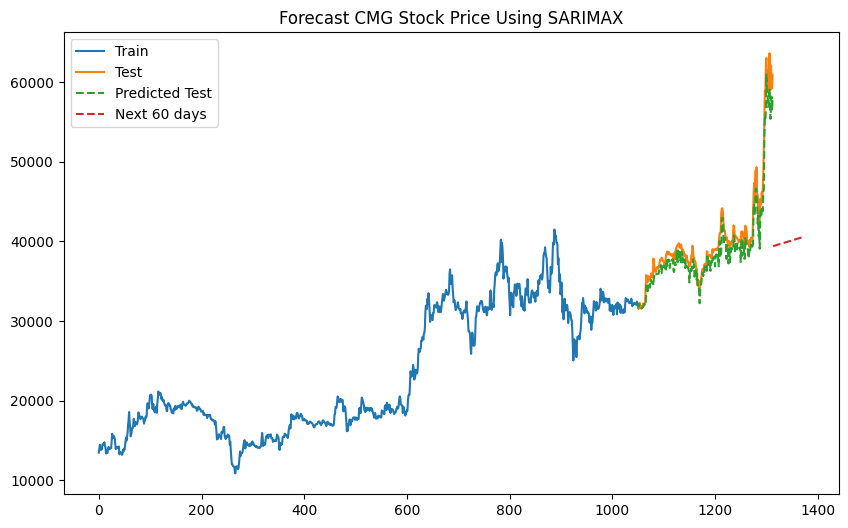

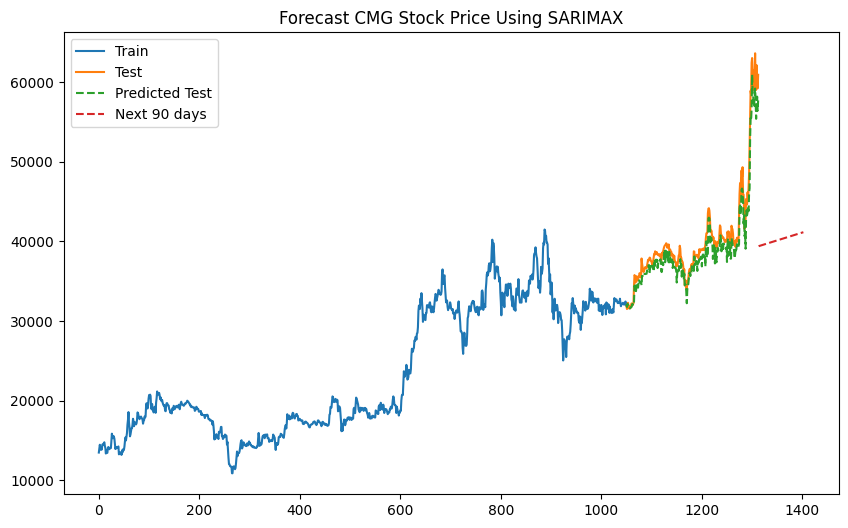

In [33]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [34]:
# Model evaluation on test set
print(f"RMSE: {rmse(y_test, y_pred_test)}")
print(f"MAE: {mae(y_test, y_pred_test)}")
print(f"MAPE: {mape(y_test, y_pred_test) * 100} %")

RMSE: 1606.5328259441783
MAE: 1266.7832240137705
MAPE: 2.9980728611462526 %
